Carregar dados e organizar

In [139]:
import pandas as pd
import numpy as np

url = "https://storage.data.gov.my/transportation/ridership_headline.csv"
df = pd.read_csv(url)

df["date"] = pd.to_datetime(df["date"], errors="raise")
df = df.sort_values("date").set_index("date")

# garante numérico
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df.head(), df.shape


(            bus_rkl  bus_rkn  bus_rpn  rail_lrt_ampang  rail_mrt_kajang  \
 date                                                                      
 2019-01-01      NaN      NaN      NaN           113357           114173   
 2019-01-02      NaN      NaN      NaN           182715           169316   
 2019-01-03      NaN      NaN      NaN           187904           175304   
 2019-01-04      NaN      NaN      NaN           198420           187891   
 2019-01-05      NaN      NaN      NaN           120773           112660   
 
             rail_lrt_kj  rail_monorail  rail_mrt_pjy  rail_ets  \
 date                                                             
 2019-01-01       139634          35804           NaN       NaN   
 2019-01-02       274224          31859           NaN       NaN   
 2019-01-03       286469          31893           NaN       NaN   
 2019-01-04       304755          34121           NaN       NaN   
 2019-01-05       145036          29950           NaN       NaN 

Garantir frequência diária e limpar valores inválidos

In [140]:
# garante um índice diário completo
full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
df = df.reindex(full_idx)
df.index.name = "date"

# negativos são inválidos pra contagem
df[df < 0] = np.nan

df.isna().mean().sort_values(ascending=False).head(10)

rail_komuter          0.669926
rail_tebrau           0.494720
rail_mrt_pjy          0.493547
bus_rkn               0.428627
bus_rkl               0.428627
bus_rpn               0.428627
rail_intercity        0.255377
rail_komuter_utara    0.255377
rail_ets              0.255377
rail_mrt_kajang       0.000000
dtype: float64

Preencher buracos curtos

In [141]:
df_clean = df.copy()

for col in df_clean.columns:
    start = df_clean[col].first_valid_index()
    if start is None:
        continue

    # só preenche a partir do primeiro dado válido (serviço começou a existir/ser reportado)
    s_valid = df_clean.loc[start:, col].interpolate(method="time", limit=7)
    df_clean.loc[start:, col] = s_valid

df_clean.isna().mean().sort_values(ascending=False).head(10)


rail_komuter          0.669926
rail_tebrau           0.494720
rail_mrt_pjy          0.493547
bus_rkn               0.428627
bus_rkl               0.428627
bus_rpn               0.428627
rail_intercity        0.255377
rail_komuter_utara    0.255377
rail_ets              0.255377
rail_mrt_kajang       0.000000
dtype: float64

Criar os alvos: total de ônibus e total de rail

In [142]:
bus_cols  = ["bus_rkl", "bus_rkn", "bus_rpn"]
rail_cols = [c for c in df_clean.columns if c.startswith("rail_")]

df_model = pd.DataFrame(index=df_clean.index)
df_model["bus_total"]  = df_clean[bus_cols].sum(axis=1, min_count=1)
df_model["rail_total"] = df_clean[rail_cols].sum(axis=1, min_count=1)

# ônibus só existe a partir de 2022-01-01 neste dataset
df_model = df_model.loc["2022-01-01":].copy()

df_model.head(), df_model.isna().sum()


(            bus_total  rail_total
 date                             
 2022-01-01   113916.0    271928.0
 2022-01-02   103221.0    225843.0
 2022-01-03   142653.0    353129.0
 2022-01-04   141753.0    362964.0
 2022-01-05   144365.0    366186.0,
 bus_total     0
 rail_total    0
 dtype: int64)

Adicionar features de calendário

In [143]:
df_feat = df_model.copy()
df_feat["dow"] = df_feat.index.dayofweek
df_feat["is_weekend"] = (df_feat["dow"] >= 5).astype(int)
df_feat["dayofyear"] = df_feat.index.dayofyear

df_feat.head()

,bus_total,rail_total,dow,is_weekend,dayofyear
date,,,,,
2022-01-01,113916.0,271928.0,5,1,1
2022-01-02,103221.0,225843.0,6,1,2
2022-01-03,142653.0,353129.0,0,0,3
2022-01-04,141753.0,362964.0,1,0,4
2022-01-05,144365.0,366186.0,2,0,5


Split temporal (80% treino, 20% teste) + normalização sem vazamento

In [144]:
from sklearn.preprocessing import MinMaxScaler

split = int(len(df_feat) * 0.8)
train = df_feat.iloc[:split]
test  = df_feat.iloc[split:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled  = scaler.transform(test)

feat_cols = train.columns.tolist()
target_cols = ["bus_total", "rail_total"]
target_idx = [feat_cols.index(c) for c in target_cols]

train_scaled.shape, test_scaled.shape


((1168, 5), (293, 5))

Criar janelas (últimos 14 dias → prever amanhã)

In [145]:
def make_windows(data, window, target_idx):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, :])
        y.append(data[i+window, list(target_idx)])
    return np.array(X), np.array(y)

window = 50

all_scaled = np.vstack([train_scaled, test_scaled])
X_all, y_all = make_windows(all_scaled, window=window, target_idx=target_idx)

cut = len(train_scaled) - window
X_train, y_train = X_all[:cut], y_all[:cut]
X_test,  y_test  = X_all[cut:], y_all[cut:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1118, 50, 5), (1118, 2), (293, 50, 5), (293, 2))

Treinar uma RNN em PyTorch

In [146]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# tensores
Xtr = torch.tensor(X_train, dtype=torch.float32)
ytr = torch.tensor(y_train, dtype=torch.float32)
Xte = torch.tensor(X_test, dtype=torch.float32)
yte = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=32, shuffle=True)

class RNNModel(nn.Module):
    def __init__(self, n_features, hidden=64, out=2):
        super().__init__()
        # self.rnn = nn.RNN(input_size=n_features, hidden_size=hidden, batch_first=True, nonlinearity="tanh")
        self.rnn = nn.GRU(input_size=n_features, hidden_size=hidden, batch_first=True)
        self.fc = nn.Linear(hidden, out)

    def forward(self, x):
        out, _ = self.rnn(x)      # (batch, time, hidden)
        last = out[:, -1, :]      # último passo
        return self.fc(last)

model = RNNModel(n_features=X_train.shape[2], hidden=64, out=2)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

# treino
for epoch in range(50):
    model.train()
    total = 0.0
    for xb, yb in train_loader:
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        total += loss.item()
    print(f"epoch {epoch+1:02d} loss {total/len(train_loader):.6f}")


epoch 01 loss 0.186268
epoch 02 loss 0.043475
epoch 03 loss 0.032090
epoch 04 loss 0.028861
epoch 05 loss 0.025802
epoch 06 loss 0.022679
epoch 07 loss 0.019699
epoch 08 loss 0.017202
epoch 09 loss 0.015414
epoch 10 loss 0.014389
epoch 11 loss 0.013419
epoch 12 loss 0.013015
epoch 13 loss 0.012502
epoch 14 loss 0.012042
epoch 15 loss 0.011531
epoch 16 loss 0.011234
epoch 17 loss 0.011072
epoch 18 loss 0.010816
epoch 19 loss 0.010631
epoch 20 loss 0.011180
epoch 21 loss 0.010417
epoch 22 loss 0.010191
epoch 23 loss 0.009985
epoch 24 loss 0.009789
epoch 25 loss 0.010073
epoch 26 loss 0.009432
epoch 27 loss 0.009374
epoch 28 loss 0.009411
epoch 29 loss 0.009337
epoch 30 loss 0.008820
epoch 31 loss 0.008826
epoch 32 loss 0.008756
epoch 33 loss 0.008513
epoch 34 loss 0.008460
epoch 35 loss 0.008235
epoch 36 loss 0.008130
epoch 37 loss 0.008022
epoch 38 loss 0.008185
epoch 39 loss 0.007922
epoch 40 loss 0.007713
epoch 41 loss 0.007823
epoch 42 loss 0.007627
epoch 43 loss 0.007655
epoch 44 lo

Avaliar no teste (MAE/RMSE) — normalizado e em passageiros reais

* MAE/RMSE normalizado

In [147]:
model.eval()
with torch.no_grad():
    pred = model(Xte).cpu().numpy()
    true = yte.cpu().numpy()

mae = np.mean(np.abs(pred - true), axis=0)
rmse = np.sqrt(np.mean((pred - true)**2, axis=0))
print("MAE norm [bus, rail]:", mae)
print("RMSE norm [bus, rail]:", rmse)


MAE norm [bus, rail]: [0.09084786 0.0840582 ]
RMSE norm [bus, rail]: [0.12243249 0.10362086]


* Desnormalizar (voltar para passageiros reais)

In [148]:
def inverse_targets(y_scaled, scaler, n_features, target_idx):
    temp = np.zeros((len(y_scaled), n_features), dtype=np.float32)
    temp[:, target_idx] = y_scaled
    inv = scaler.inverse_transform(temp)
    return inv[:, target_idx]

n_features = len(feat_cols)
pred_orig = inverse_targets(pred, scaler, n_features, target_idx)
true_orig = inverse_targets(true, scaler, n_features, target_idx)

mae_orig = np.mean(np.abs(pred_orig - true_orig), axis=0)
rmse_orig = np.sqrt(np.mean((pred_orig - true_orig)**2, axis=0))

print("MAE original [bus, rail]:", mae_orig)
print("RMSE original [bus, rail]:", rmse_orig)

MAE original [bus, rail]: [19532.293 97709.75 ]
RMSE original [bus, rail]: [ 26322.986 120449.59 ]


Baseline (amanhã = hoje) pra comparar

In [149]:
baseline_pred = X_test[:, -1, :][:, target_idx]  # último dia da janela

mae_b = np.mean(np.abs(baseline_pred - y_test), axis=0)
rmse_b = np.sqrt(np.mean((baseline_pred - y_test)**2, axis=0))

baseline_orig = inverse_targets(baseline_pred, scaler, n_features, target_idx)
ytest_orig = inverse_targets(y_test, scaler, n_features, target_idx)

mae_b_orig = np.mean(np.abs(baseline_orig - ytest_orig), axis=0)
rmse_b_orig = np.sqrt(np.mean((baseline_orig - ytest_orig)**2, axis=0))

print("Baseline MAE original [bus, rail]:", mae_b_orig)
print("Baseline RMSE original [bus, rail]:", rmse_b_orig)

Baseline MAE original [bus, rail]: [ 30997.291 143171.69 ]
Baseline RMSE original [bus, rail]: [ 47899.176 215776.64 ]


## O que significa “estacionário” (em 30 segundos)

Uma série é estacionária se:

* a média não muda no tempo
* a variância não muda no tempo
* a dependência temporal é estável

📌 ARIMA/SARIMA exigem (quase) estacionariedade.

📌 Passageiros NÃO são estacionários → têm tendência + sazonalidade.

## Teste de estacionariedade (ADF)

In [150]:
from statsmodels.tsa.stattools import adfuller

y = df_model["bus_total"]   # ou rail_total

# Augmented Dickey-Fuller (ADF)
# H₀: a série não é estacionária
# Queremos p-value < 0.05

adf = adfuller(y.dropna())
print("ADF statistic:", adf[0])
print("p-value:", adf[1])

ADF statistic: -2.1106071202646146
p-value: 0.24027087158888555


## Tornar a série estacionária

* Diferenciação (remove tendência)

In [151]:
y_diff = y.diff().dropna()

adf_diff = adfuller(y_diff)
print("p-value após 1ª diferença:", adf_diff[1])


p-value após 1ª diferença: 4.549533144621898e-25


* Diferenciação sazonal (remove padrão semanal)

In [152]:
# Como os dados são diários, sazonalidade semanal = 7 dias:

y_seasonal = y.diff(7).dropna()

adf_seasonal = adfuller(y_seasonal)
print("p-value após diferença sazonal:", adf_seasonal[1])

p-value após diferença sazonal: 5.67184415196386e-25


## ACF e PACF (para justificar parâmetros)

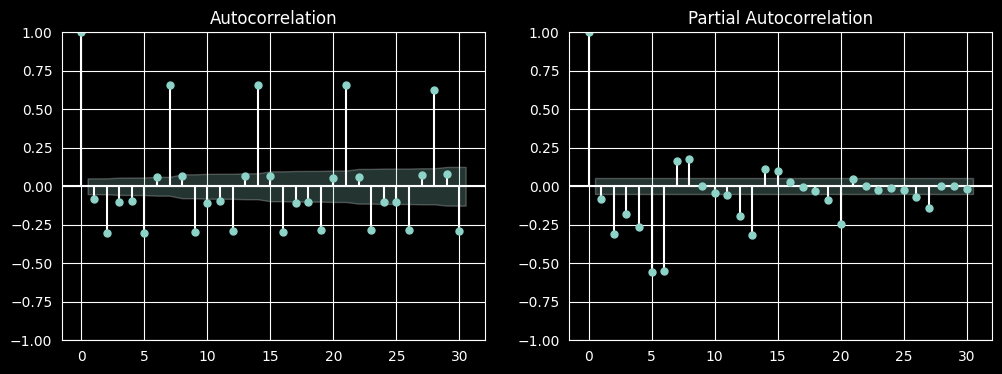

In [153]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(y_diff, lags=30, ax=ax[0])
plot_pacf(y_diff, lags=30, ax=ax[1])
plt.show()

## Ajustar um modelo SARIMA

In [154]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    y,
    order=(1,1,1),          # ARIMA
    seasonal_order=(1,1,1,7),  # sazonal semanal
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = model.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         bus_total   No. Observations:                 1461
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -16506.123
Date:                           Fri, 16 Jan 2026   AIC                          33022.247
Time:                                   11:07:27   BIC                          33048.622
Sample:                               01-01-2022   HQIC                         33032.091
                                    - 12-31-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0748      0.058      1.285      0.199      -0.039       0.189
ma.L1         -0.6941      0.047    -14.721

## Previsão com SARIMA (dia seguinte)

In [155]:
forecast = res.get_forecast(steps=1)
pred = forecast.predicted_mean.iloc[0]

print("Previsão SARIMA para amanhã:", pred)


Previsão SARIMA para amanhã: 252174.945585099


## Avaliar SARIMA (mesma métrica do RNN)

In [156]:
train_size = int(len(y) * 0.8)
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]

model = SARIMAX(
    y_train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = model.fit(disp=False)

pred = res.forecast(steps=len(y_test))

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

mae, rmse


(35470.371895346056, np.float64(45569.8375686455))

## Gráfico Real vs Previsto – SARIMA

* 1.1 Treino + previsão no período de teste

In [157]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import numpy as np

# série alvo
y = df_model["bus_total"]

# split temporal
split = int(len(y) * 0.8)
y_train = y.iloc[:split]
y_test  = y.iloc[split:]

# SARIMA
model = SARIMAX(
    y_train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = model.fit(disp=False)

# previsão para o período de teste
y_pred = res.forecast(steps=len(y_test))


* 1.2 Gráfico

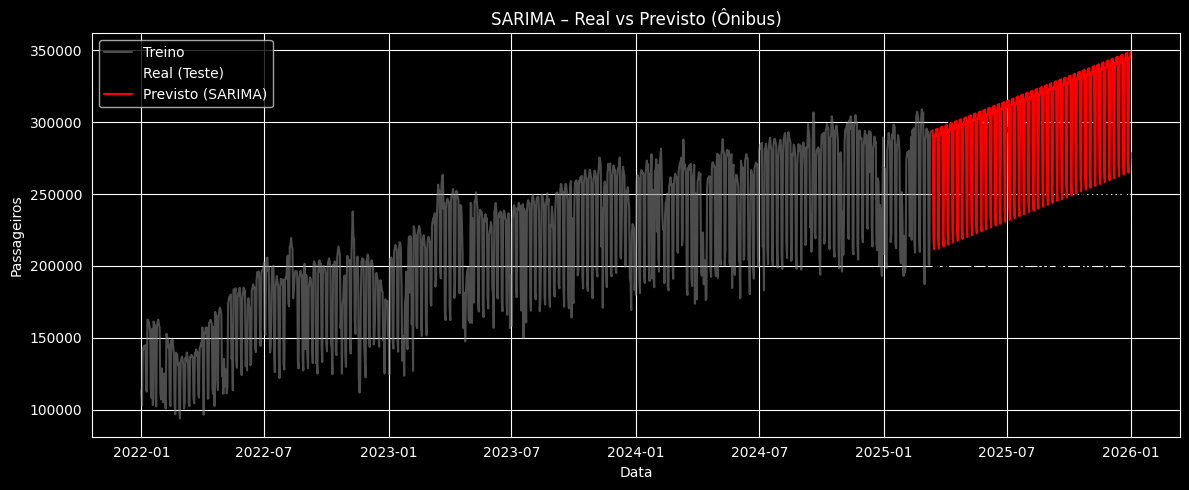

In [158]:
plt.figure(figsize=(12,5))
plt.plot(y_train.index, y_train, label="Treino", color="gray", alpha=0.6)
plt.plot(y_test.index, y_test, label="Real (Teste)", color="black")
plt.plot(y_test.index, y_pred, label="Previsto (SARIMA)", color="red")

plt.title("SARIMA – Real vs Previsto (Ônibus)")
plt.xlabel("Data")
plt.ylabel("Passageiros")
plt.legend()
plt.tight_layout()
plt.show()

## Gráfico Real vs Previsto – RNN / GRU
* 2.1 Preparar índices corretos do teste

df_feat len: 1461
y_test len: 293
true_orig shape: (293, 2)
pred_orig shape: (293, 2)
Usando n = 293


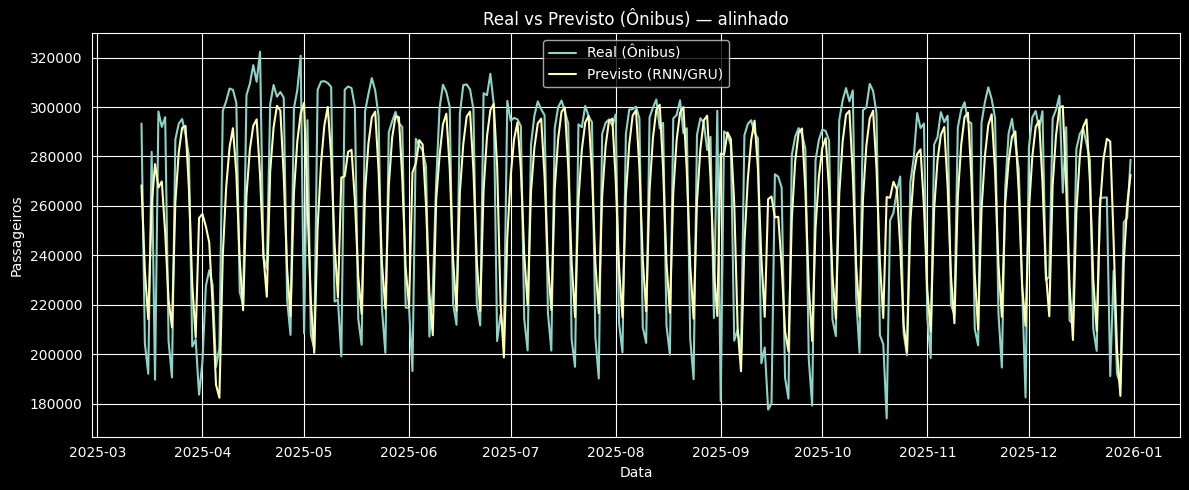

In [159]:
import numpy as np
import matplotlib.pyplot as plt

# garanta que são arrays numpy
true_arr = np.asarray(true_orig)
pred_arr = np.asarray(pred_orig)

# checagens (vai imprimir, mas não trava)
print("df_feat len:", len(df_feat))
print("y_test len:", len(y_test))
print("true_orig shape:", true_arr.shape)
print("pred_orig shape:", pred_arr.shape)

# pega o tamanho que existe em TODOS (evita mismatch)
n = min(len(df_feat.index), len(true_arr), len(pred_arr))
print("Usando n =", n)

# alinha índice e séries pelo mesmo n
idx = df_feat.index[-n:]
true_bus = true_arr[-n:, 0]
pred_bus = pred_arr[-n:, 0]

plt.figure(figsize=(12,5))
plt.plot(idx, true_bus, label="Real (Ônibus)")
plt.plot(idx, pred_bus, label="Previsto (RNN/GRU)")
plt.title("Real vs Previsto (Ônibus) — alinhado")
plt.xlabel("Data")
plt.ylabel("Passageiros")
plt.legend()
plt.tight_layout()
plt.show()


## Gráfico comparativo

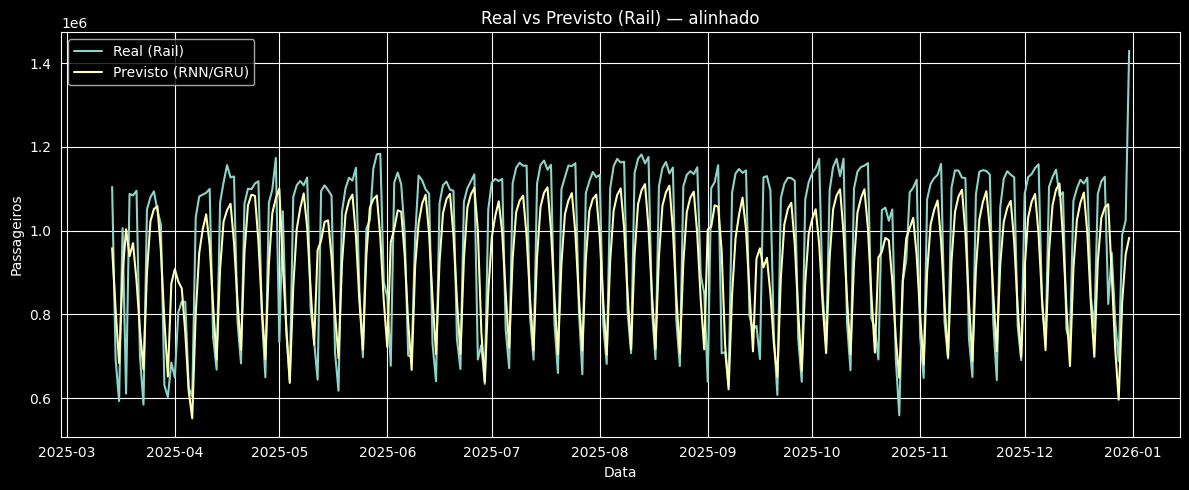

In [160]:
idx = df_feat.index[-n:]
true_rail = true_arr[-n:, 1]
pred_rail = pred_arr[-n:, 1]

plt.figure(figsize=(12,5))
plt.plot(idx, true_rail, label="Real (Rail)")
plt.plot(idx, pred_rail, label="Previsto (RNN/GRU)")
plt.title("Real vs Previsto (Rail) — alinhado")
plt.xlabel("Data")
plt.ylabel("Passageiros")
plt.legend()
plt.tight_layout()
plt.show()

In [161]:
import torch
from torch.utils.data import Dataset

class WindowDataset(Dataset):
    def __init__(self, data, window, target_idx):
        """
        data: array numpy (N, features)
        window: tamanho da janela (W)
        target_idx: índices das colunas alvo
        """
        self.data = data
        self.window = window
        self.target_idx = target_idx

    def __len__(self):
        # número de janelas
        return len(self.data) - self.window

    def __getitem__(self, idx):
        # X: janela [idx : idx+window]
        X = self.data[idx : idx + self.window, :]

        # y: alvo no passo seguinte
        y = self.data[idx + self.window, self.target_idx]

        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

O __getitem__ permite gerar janelas temporais sob demanda. Cada índice corresponde a uma janela de tamanho W e ao valor-alvo no passo seguinte, evitando a criação explícita de todas as janelas e reduzindo uso de memória.

O número de amostras é dado por len(dataset) = N − W, pois cada janela consome W observações para prever o próximo passo.

In [162]:
window = 30
target_idx = [feat_cols.index("bus_total"), feat_cols.index("rail_total")]

dataset = WindowDataset(train_scaled, window, target_idx)

print("Número de janelas:", len(dataset))
X0, y0 = dataset[0]

print("X0 shape:", X0.shape)  # (30, features)
print("y0 shape:", y0.shape)  # (2,)

Número de janelas: 1138
X0 shape: torch.Size([30, 5])
y0 shape: torch.Size([2])


In [163]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=32, shuffle=False)

for X_batch, y_batch in loader:
    print(X_batch.shape)  # (batch, window, features)
    print(y_batch.shape)  # (batch, 2)
    break


torch.Size([32, 30, 5])
torch.Size([32, 2])


model = nn.Sequential(
    nn.Flaten(),
    nn.Linear(window * len(feat_cols)),
    nn.ReLU(),
    nn.Linear(64),
    nn.ReLU(),
    nn.Linear(2)
    )


In [168]:
import torch.nn as nn

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(window * len(feat_cols)),
    nn.ReLU(),
    nn.Linear(64),
    nn.ReLU(),
    nn.Linear(2)
    )

TypeError: Linear.__init__() missing 1 required positional argument: 'out_features'